# Canadian cancer statistics: a mixed story

I recently [reviewed](https://bioeconometrician.github.io/first_cell/) Azra Raza's new book *The First Cell*, whose primary thesis is that cancer research has failed to translate into effective treatments due to a combination or poor incentives and a flawed experimental paradigm. The book's focus was on the American healthcare system and made few international comparisons. This piqued my curiosity as to the . The cancer that Dr. Raza treats, myelodysplastic syndromes (MDS) and its evolutionary successor, malignancy acute myeloid leukemia (AML), are one of the cancer types that have seen almost no improvement in therapeutic options in the last 30 years. Despite the hype about "blockbuster" therapies being "game changers", the "immunotherapy revolution" has been remarkably unimpressive, with overall gains usually measured in [months](https://jamanetwork.com/journals/jamaotolaryngology/article-abstract/1891387). This is hardly surprising given that only [5% of cancer drugs](https://tinyurl.com/y2n8rnzb) even reach the market. 

Oncologists will anecdotally tell you that the number of cancer patients in almost every specialty is rising each year. But the main reason for the phenomena is almost surely the rapidly aging population. I set out to answer three questions:

1. How has Canadian cancer mortality changed over time?
2. How many cancer deaths are attributable to Canada's aging population?
3. Are we getting better at treating cancer in Canada?

I CAN'T KNOW HOW MUCH IS BECAUSE OF NEW DRUGS, BUT DECLINING AGE-ADJUSTED MORTALITY RATES SHOULD BE USED
ALSO, I DO NOT FOCUS OF 5-YEAR SURVIVAL RATES BECAUSE THEY CAN BE MISLEADING: LEAD-TIME BIAS DUE TO SCREENING. CANCER DEATHS ARE AT LEAST MUCH EASIER TO QUANTIFY.[[^1]]
IN TERMS OF COST PLANNING, THIS ANALYSIS IS USELESS, WE NEED TO BUDGET FOR THIS LINEAR INCREASE BUT I'M MORE INTERESTED IN "ARE WE GETTING BETTER"

[^1]: Determining the cause of death is not always easy however. There is certainly some error in this calculation. Furthermore, since most people that die of cancer are elderly, and elderly patients tend to have comorbidities, it is difficult to disentangle what pathology actually killed a patient. Despite these caveats, the cause of death is still more reliable and consistent across years than other measurements. 

## (1) Data sources

To calculate the number of deaths I used deaths by *Malignant neoplasms* from StatsCan [table 13-10-0394-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310039401): *Leading causes of death, total population, by age group*. Cancer makes up the plurality of deaths of annual deaths in Canada (30%), followed by heart disease. This table can be further decomposed into the type of neoplasm with [table 13-10-0142-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310014201): *Deaths, by cause, Chapter II: Neoplasms*, to break down ICD-10 cause of death codes C00-C97. To make the number of deaths comparable between years, cancer deaths are normalized by the population (per 100K persons) using StatsCan [table 17-10-0005-01](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000501). Note that a copy of the `csv` files in the analysis below can be found [here](https://github.com/erikdrysdale/erikdrysdale.github.io/tree/master/_rmd/extra_cancer). 

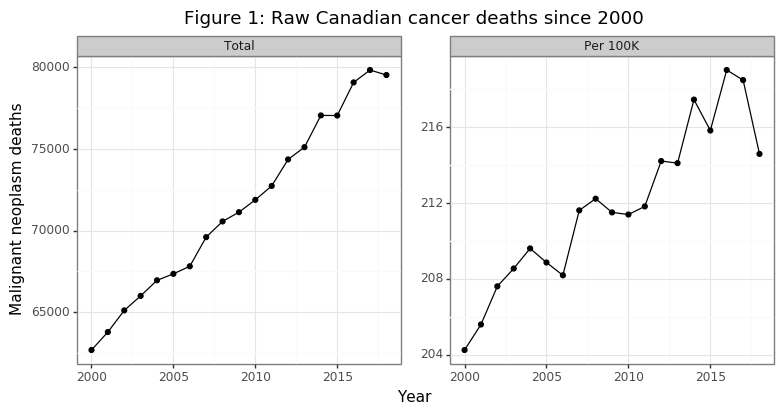

<ggplot: (8739441806317)>

In [32]:
import os
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
from matplotlib import cm, colors
from plydata.cat_tools import *

# Load the CSV files
df_cancer = pd.read_csv('1310039401.csv',usecols=['year','number'])
df_cancer.rename(columns={'year':'years','number':'cancer'}, inplace=True)
df_pop = pd.read_csv('1710000501.csv')
df_pop = df_pop.melt('years',None,'grp','population')
# Raw rate per 100K
df_pop_total = df_pop.query('grp=="All ages"').drop(columns='grp').rename(columns={'population':'total'})
df_rate = df_pop_total.merge(df_cancer,how='right',on='years').assign(rate=lambda x: x.cancer/(x.total/100000))
# plot
tmp = df_rate.melt('years',['cancer','rate'],'tt')
tmp.head()
plotnine.options.figure_size = (9, 4)
gg_agg = (ggplot(tmp,aes(x='years',y='value')) + theme_bw() + 
          geom_point() + geom_line() + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Year') + 
          ggtitle('Figure 1: Raw Canadian cancer deaths since 2000') + 
          theme(subplots_adjust={'wspace': 0.15}))
gg_agg

Figure 1 shows that the number of annual cancer deaths has been rising with a linear trend from 2000 to 2018. A staggering 1.36 million Canadians have died of cancer in this time frame. The second panel in the figure also shows that the death rate per capita has also been increasing, although in a less smooth fashion. Overall per capita death rates are about 4% higher in 2018 then they were in 2000. These data are not encouraging. However, it is important to remember that these plots do not take into account the change in the composition of the Canadian population (i.e. our society is aging). As Raza points out in her book, the cancer's that emerge in older populations are much more genetically complex due to a higher mutational load. Successful treatments are therefore likely to be, at best, temporary since the cancer cells that survive will now resistant to the treatment, and there is more variations in cells for natural selection to occur over.

## (2) Adjusting for age

The goal of this section is to estimate how many people would have died of cancer had the population structure of Canada stayed the same. Even if age-specific cancer mortality rates are declining for all population groups, cancer deaths per capita can still rise if the decline in mortality is offset by a high share of the population going into the higher death rate age groups. One challenge when dealing with publicly available census data is that the age categories are usually aggregated. The data discussed in section (1) uses 10-year age ranges (e.g. 45-54) for age categories. One [subtle effect](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4763761/) of an aging population may be to change the distribution within these age bins (e.g. more 54 compared to 45 year olds over time). I do not, and cannot account for this. However, the bias of this confounder will be to understate declines in age-specific deaths if the population is generally aging. As will soon be made clear, I show age-adjusted declines in mortality, so this bias would not change the sign the interpretation.

Two statistical facts drive the increase in per capita cancer deaths in Canada, as Figure 2A shows below:

1. The Canadian population is aging
2. Older Canadians are more likely to die of cancer

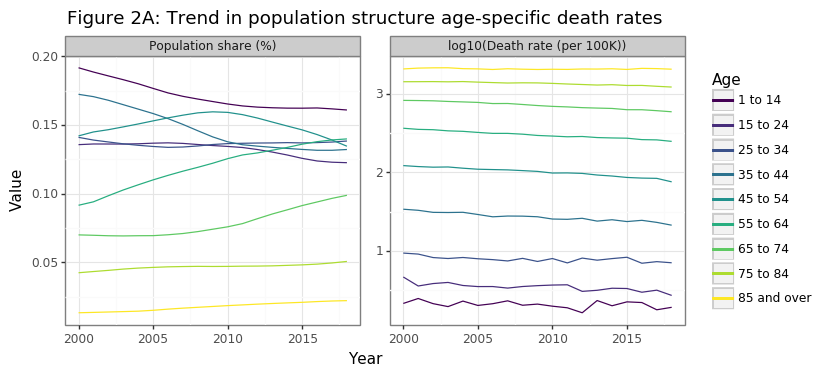

<ggplot: (8739441790553)>


In [124]:
# Age-specific cancer
df_age = pd.read_csv('1310039401_by_age.csv')
df_age.age = df_age.age.str.split('\\,\\s',expand=True).iloc[:,1]
df_age.age = df_age.age.fillna(method='ffill')
df_age.age = df_age.age.str.replace('\\syears','')
# Age-specific population
di_age = {'0 to 4':'1 to 14', '5 to 9':'1 to 14', '10 to 14':'1 to 14',
          '15 to 19':'15 to 24', '20 to 24':'15 to 24',
          '25 to 29':'25 to 34', '30 to 34':'25 to 34',
          '35 to 39':'35 to 44', '40 to 44':'35 to 44',
          '45 to 49':'45 to 54', '50 to 54':'45 to 54',
          '55 to 59':'55 to 64', '60 to 64':'55 to 64',
          '65 to 69':'65 to 74', '70 to 74':'65 to 74',
          '75 to 79':'75 to 84', '80 to 84':'75 to 84',
          '85 to 89':'85 and over','90 to 94':'85 and over',
          '95 to 99':'85 and over', '100 and over':'85 and over',
          'Under 1 year':'1 to 14', '1 to 4':'1 to 14', '90 and over':'85 and over'}
df_pop_sub = df_pop.query('grp!="All ages"').assign(grp=lambda x: x.grp.str.replace('\\syears',''))
df_pop_sub = df_pop_sub.assign(age=lambda x: x.grp.map(di_age)).groupby(['years','age']).population.sum().reset_index()
# Merge
df_age = df_pop_sub.merge(df_age,how='right',on=['years','age'])
df_age = df_age.assign(rate=lambda x: x.number/(x.population/1e5))
df_age = df_age.merge(df_pop_total,'left','years').assign(pop_share=lambda x: x.population / x.total)
tmp = df_age.assign(rate=lambda x: np.log10(x.rate)).melt(['years','age'],['pop_share','rate'],'tt')
# Repeat for index
tmp2 = tmp.groupby(['age','tt']).head(1).drop(columns='years').rename(columns={'value':'bl'})
tmp = tmp.merge(tmp2, 'left', ['age','tt']).assign(idx=lambda x: x.value/x.bl*100)

lblz = list(tmp.age.unique())
n_age = len(lblz)
mat = cm.get_cmap('viridis',n_age).colors
colz = []
for ii in range(n_age):
  colz.append(colors.to_hex(mat[ii]))
plotnine.options.figure_size = (8, 3.5)
di_age_rate = {'pop_share':'Population share (%)', 'rate':'log10(Death rate (per 100K))'}
gg_age_rate = (ggplot(tmp, aes(x='years',y='value',color='age',group='age')) + theme_bw() + 
               geom_line() + labs(y='Value',x='Year') + 
               facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_age_rate)) + 
               theme(subplots_adjust={'wspace':0.1}) + 
               scale_color_manual(name='Age',values=colz,labels=lblz) + 
               ggtitle("Figure 2A: Trend in population structure age-specific death rates"))
print(gg_age_rate)

Figure 2A shows that Canadian population has slowly been aging over the last 20 years. The changes have been modest but sustained. From 2000 to 2018 the share of population >55 years old increased from 22% to 31%, and the equivalent figure for 65+ was 12 to 17%. The second panel in Figure 2A shows why, from the perspective of overall cancer death rates, this affect have tremendous consequences for death rates. The cancer death rate grows exponentially by age category. This is why 85+ year olds are a 1000 times more likely than children (1-14) to die of cancer. Every decade increase effectively doubles or triples the age-specific cancer risk. Hence a 75-84 year old is four times more likely than a 55-64 to develop cancer.

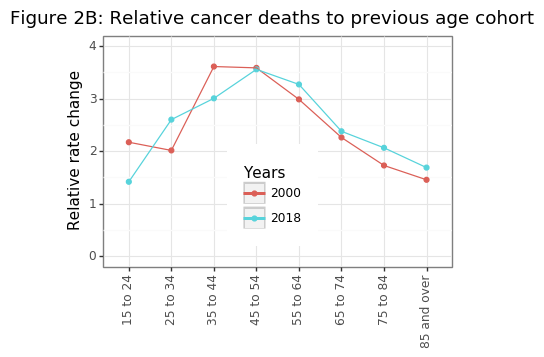

<ggplot: (8739437436385)>

In [126]:
tmp3 = df_age[df_age.years.isin([2000,2018])].sort_values(['years','age'])
tmp3 = tmp3.assign(rate_d=lambda x: x.rate/x.groupby('years').rate.shift(1))
tmp3 = tmp3[tmp3.rate_d.notnull()].assign(years=lambda x: pd.Categorical(x.years))
plotnine.options.figure_size = (4.5, 3)
gg_rate_delta = (ggplot(tmp3, aes(x='age',y='rate_d',color='years',group='years')) + theme_bw() + 
                 geom_point() + geom_line() + 
                 ggtitle('Figure 2B: Relative cancer deaths to previous age cohort') + 
                 theme(axis_title_x=element_blank(), axis_text_x=element_text(angle=90),
                      legend_position=(0.5,0.35)) + 
                 labs(y='Relative rate change') + 
                 scale_y_continuous(limits=[0,4],breaks=list(np.arange(0,5,1))) + 
                 scale_color_discrete(name='Years'))
gg_rate_delta

Figure 2B shows that exponential trend is age-specific mortality rates has been fairly constant over 20 years suggesting that the increases in cancer risk are biological. Environmental factors may also be present (e.g. lung cancer takes decades to kill you), but they are likely consistent across time too. To make the trends more clear from Figure 2A, it is useful to index the population shares and age-specific cancer mortality rates to the year 2000.

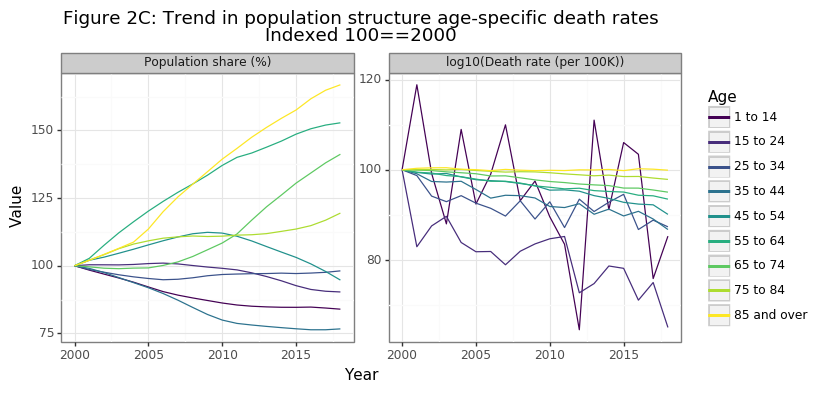

<ggplot: (8739439076741)>


In [128]:
plotnine.options.figure_size = (8, 3.5)
gg_age_rate_idx = (ggplot(tmp, aes(x='years',y='idx',color='age',group='age')) + theme_bw() + 
               geom_line() + labs(y='Value',x='Year') + 
               facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_age_rate)) + 
               theme(subplots_adjust={'wspace':0.12}) + 
               scale_color_manual(name='Age',values=colz,labels=lblz) + 
               ggtitle("Figure 2C: Trend in population structure age-specific death rates\nIndexed 100==2000"))
print(gg_age_rate_idx)

Figure 2C shows that the biggest relative gains from the 65-74, 75-84, and 85% age categories, with the latter increasing by more than 60% in 20 years. Recall that because 85+ cancer deaths are extremely high, large increases into this category cause overall cancer death numbers to increase drastically. As a final figure lets see the aggregate mortality broken down by age.

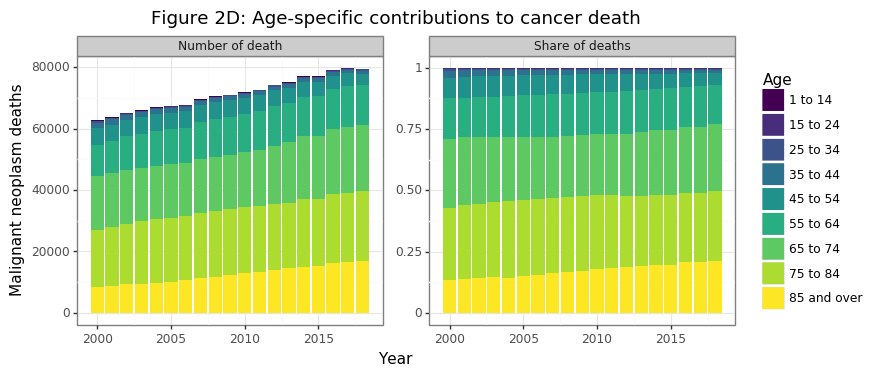

<ggplot: (8739441421605)>

In [158]:
tmp4 = df_age.merge(df_cancer,'left','years').assign(share = lambda x: x.number/x.cancer)
tmp4 = tmp4.melt(['years','age'],['number','share'],'tt')

plotnine.options.figure_size = (8.5, 3.5)
di_tt = {'number':'Number of death','share':'Share of deaths'}
gg_age_breakdown = (ggplot(tmp4, aes(x='years',weight='value',fill='age')) + theme_bw() + 
                    labs(y='Malignant neoplasm deaths', x='Year') + 
                    geom_bar() + facet_wrap('~tt',scales='free_y',labeller=labeller(tt=di_tt)) + 
                    ggtitle('Figure 2D: Age-specific contributions to cancer death') + 
                    scale_fill_manual(name='Age',values=colz,labels=lblz) + 
                    theme(subplots_adjust={'wspace': 0.15}))
gg_age_breakdown

Figure 4 shows that half of all cancer deaths today come from 75+ year olds, 75% from 65+, and more than 95% for 55+. 

NOW WE CAN ESTIMATE COUNTERFACTUAL DEATH RATES

SOME FORMULA

/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


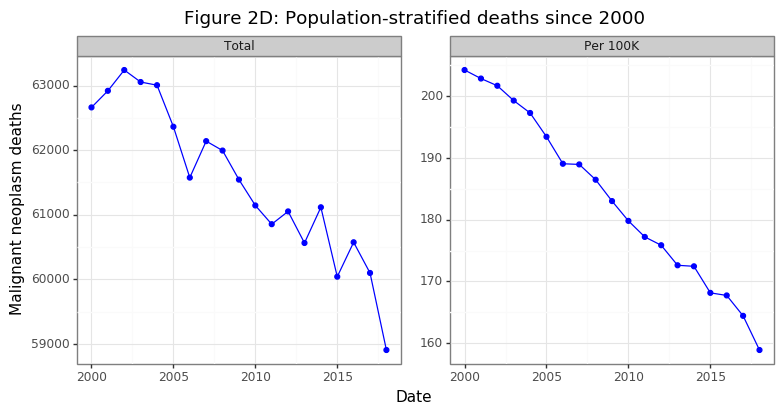

<ggplot: (8739438931225)>

In [134]:
df_pop_r = df_pop_total.assign(r=lambda x: x.total/x.total.head(1).values).drop(columns='total')
df_idx = df_age.assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN)).drop(columns='number')
df_idx.population = df_idx.groupby('age').population.fillna(method='ffill')
df_idx = df_idx.merge(df_pop_r,'left','years').assign(population=lambda x: x.population*x.r)
df_idx = df_idx.assign(cancer=lambda x: x.rate*(x.population/1e5))
df_idx = df_idx.groupby('years')['population','cancer'].sum().astype(int).reset_index()
df_idx = df_idx.assign(rate=lambda x: x.cancer/(x.population/1e5))

tmp3 = df_idx.melt('years',['cancer','rate'],'tt')
plotnine.options.figure_size = (9, 4)
gg_theory = (ggplot(tmp3,aes(x='years',y='value')) + theme_bw() + 
          geom_point(color='blue') + geom_line(color='blue') + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Date') + 
          ggtitle('Figure 2D: Population-stratified deaths since 2000') + 
          theme(subplots_adjust={'wspace': 0.15}))
gg_theory

### Age-specific mortality factors


In [17]:
df_type = pd.read_csv('1310014201_type_age.csv')
df_type.rename(columns={'Age group':'age','Cause of death (ICD-10)':'cod','VALUE':'number'},inplace=True)
drop_age = ['Total, all ages','Age, not stated']
drop_cod = ['Total, all causes of death [A00-Y89]','Chapter II: Neoplasms [C00-D48]','Malignant neoplasms [C00-C97]']
df_type = df_type[~(df_type.age.isin(drop_age) | df_type.cod.isin(drop_cod))].reset_index(None,True)
df_type.age = df_type.age.str.replace('\\syears','').map(di_age)
df_type.cod = df_type.cod.str.replace('Malignant neoplasms{0,1} of ','').str.split('\\s\\[',expand=True).iloc[:,0]
di_cod = {'Melanoma and other malignant neoplasms of skin':'melanoma',
       'bone and articular cartilage':'bone',
       'breast':'breast', 'digestive organs':'digestive',
       'eye, brain and other parts of central nervous system':'brain/eye/CNS',
       'female genital organs':'female sex organ',
       'ill-defined, secondary and unspecified sites':'ill-defined',
       'lip, oral cavity and pharynx':'mouth',
       'lymphoid, haematopoietic and related tissue':'lymphoid',
       'male genital organs':'male sex organ',
       'mesothelial and soft tissue':'mesothelial',
       'respiratory and intrathoracic organs':'respitory',
       'thyroid and other endocrine glands':'thryoid',
       'urinary tract':'urinary'}
df_type = df_type.assign(cod=lambda x: x.cod.map(di_cod))
df_type = df_type.merge(df_age[['years','age','population']],'left',['years','age'])
df_type = df_type.assign(rate=lambda x: x.number/(x.population/1e5))
# Calculation population-consistent population
df_alt_type = df_type.drop(columns='number').assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN))
df_alt_type.population = df_alt_type.groupby(['age','age']).population.fillna(method='ffill')
df_alt_type = df_alt_type.merge(df_pop_r,'left','years').assign(population=lambda x: (x.population*x.r).astype(int))
df_alt_type = df_alt_type.assign(number=lambda x: x.rate*x.population/1e5)
n_fac = 6
df_alt_type = df_alt_type.assign(cod2=lambda x: cat_lump(c=x.cod,w=x.number,n=n_fac))
tmp1 = df_alt_type.groupby(['years','age','cod2']).number.sum().reset_index()
tmp1 = tmp1.groupby(['years','cod2']).number.sum().reset_index()
df_cod2 = tmp1.merge(df_pop_total,'left','years').assign(rate=lambda x: x.number/(x.total/1e5))
df_cod2 = df_cod2.sort_values(['cod2','years']).reset_index(None,True)
df_cod2 = df_cod2.assign(tmp=lambda x: pd.Series(np.where(x.years==x.years.head(1).values[0],x.rate,np.NaN)).fillna(method='ffill'))
df_cod2 = df_cod2.assign(idx=lambda x: x.rate/x.tmp, rate_diff=lambda x: x.rate-x.tmp)
df_cod2_long = df_cod2.melt(['years','cod2'],['rate','idx'],'tt')

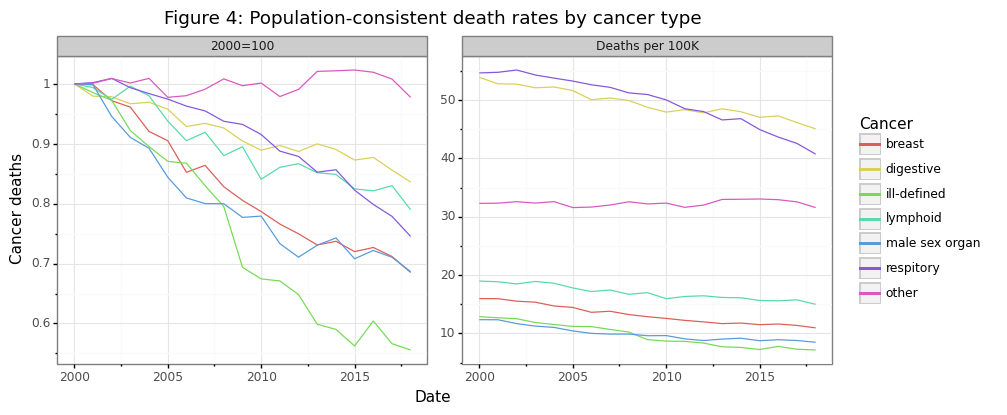

<ggplot: (8773570917836)>

In [12]:
plotnine.options.figure_size = (10, 4)
gg_cod = (ggplot(df_cod2_long, aes(x='years',y='value',color='cod2')) + 
          theme_bw() + geom_path() + 
          labs(x='Date',y='Cancer deaths') + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'idx':'2000=100','rate':'Deaths per 100K'})) + 
          ggtitle('Figure 4: Population-consistent death rates by cancer type') + 
          theme(panel_spacing_x=0.35) + 
          scale_color_discrete(name='Cancer'))
gg_cod

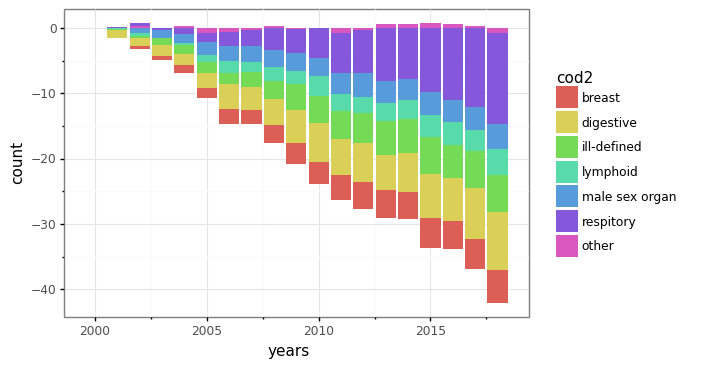

<ggplot: (8773570312396)>

In [26]:
plotnine.options.figure_size = (6, 4)
gg_diff = (ggplot(df_cod2,aes(x='years',weight='rate_diff',fill='cod2')) + 
           theme_bw() + geom_bar())
gg_diff

## (3) Conclusion

In [10]:
# tmp1 = df_cod2[['years','cod2','number']].rename(columns={'number':'counter'})
# tmp2 = df_type.assign(cod2=lambda x: cat_lump(c=x.cod,w=x.number,n=n_fac)).groupby(['years','cod2']).number.sum().reset_index()
# df_saved = tmp2.merge(tmp1,'left',['years','cod2']).assign(saved=lambda x: x.number - x.counter)
# plotnine.options.figure_size = (6, 4)
# gg_saved = (ggplot(df_saved,aes(x='years',weight='saved',fill='cod2')) + 
#             theme_bw() + geom_bar())
# gg_saved